In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
sns.set()

In [2]:
#Build NA covid data for all airport comparisons
# Build total + new NA cases
NaData = pd.read_csv("Archieved-Data/casesNA.csv", compression = 'gzip')
NaData["Date"] = pd.to_datetime(NaData["Date"])
NaSums = NaData.groupby(NaData['Date']).sum().reset_index()
naCases = NaSums[['Date','Confirmed']]
temp = naCases.shift(1)
naCases['New'] = naCases['Confirmed'] - temp['Confirmed']
naCases.loc[0,"New"] = 0
new_cases_smooth = lowess(naCases['New'], naCases["Date"], frac =0.05)
confirm_smooth = lowess(naCases['Confirmed'], naCases["Date"], frac =0.05)
naCases['New_smooth'] = new_cases_smooth[:,1]
naCases['Confirm_smooth'] = confirm_smooth[:,1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [3]:
yeg = pd.read_csv('yeg4analyze_both.csv',index_col =0, parse_dates = [1])
yegCases = pd.read_csv('Covid-Data/yeg-modified.csv', index_col =0, parse_dates = [5])

yeg["Date"] = pd.to_datetime(yeg["Date"])
yegCases["Date"] = pd.to_datetime(yegCases["Date"])

yegCases.loc[0, "Difference"] = 0

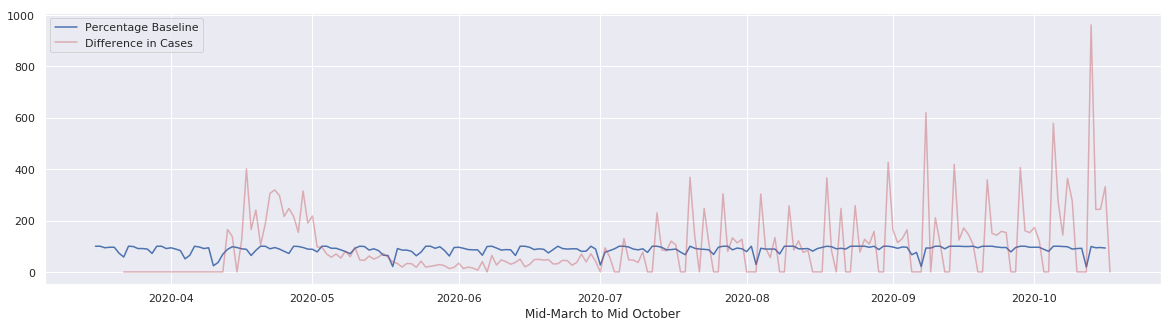

In [37]:
plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yegCases["Date"], yegCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yegCases["Date"], yegCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.savefig('graphs/YEG.svg')

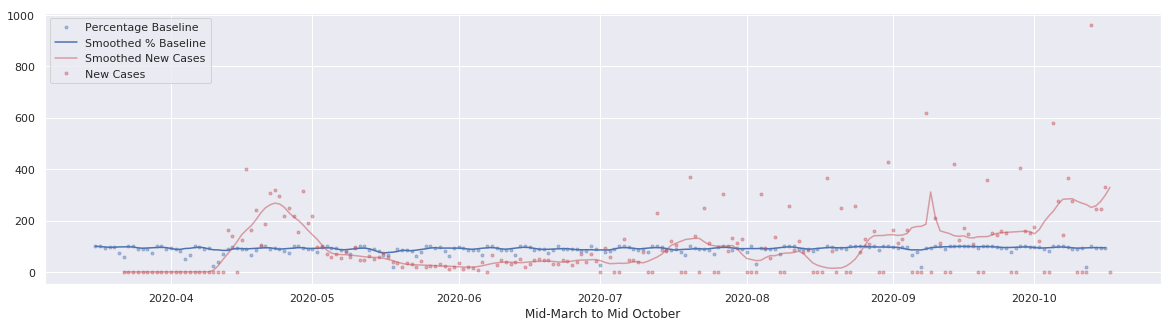

In [38]:
# Small curve in initial phase (Mid-Apr), flattened down shortly after 
# Steep increases after the Summer - look for causes 
# Called in military to assist with rising cases; lockdown
# % Baseline didn't change dramatically (decrease in business trips and international travel)
# Small dips

new_cases_smooth = lowess(yegCases['Difference'], yegCases["timestamp"], frac =0.05)
#to reduce weekly cycle effect 7/214 = 0.327
baseline_smooth = lowess(yeg['PercentOfBaseline'], yeg["Date"], frac =0.04) 
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yeg['Baseline_smooth'] = baseline_smooth[:,1]

# Ensure both yeg and yegCases start and end on the same dates
if (yeg.count().loc['Date'] != yegCases.count().loc['Date']):
    joined = yegCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yeg[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yegCases["Diff_smooth"]
    y = yeg["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yeg["Date"], yeg['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yegCases["Date"], yegCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yegCases["Date"], yegCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.savefig('graphs/YEGFiltered.svg')

0.2578346846082401


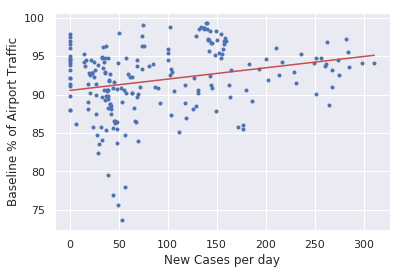

In [39]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

# 311 = max(X)
linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')
plt.savefig('graphs/YEGCorr1.svg')
# r-value: Slight but negligible correlation 
# imbalanced data??

0.37694935879079305


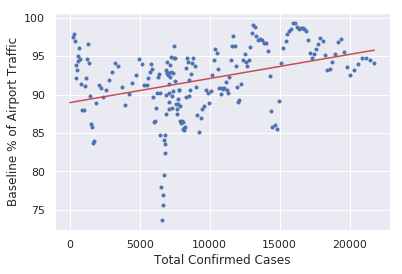

In [40]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')
plt.savefig('graphs/YEGCorr2.svg')
# r-value: slight positive correlation 

0.943165896378019
0.8639068698377862


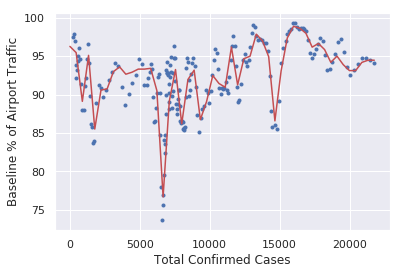

In [41]:
X = np.stack([confirmX], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,y)
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

poly_regress = make_pipeline(
    MinMaxScaler(),
    #PolynomialFeatures(degree=2, include_bias = True),
    #LinearRegression(fit_intercept = False)
    KNeighborsRegressor(3)
)
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,max(confirmX))],axis=1)
plt.plot(linearX, poly_regress.predict(linearX), 'r-')

# Hmmm... not too bad. Could be smoothed out more
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
plt.savefig('graphs/YEGCorr3.svg')

-0.40961132002337414
-0.18832522786135192
-0.4543429005229191


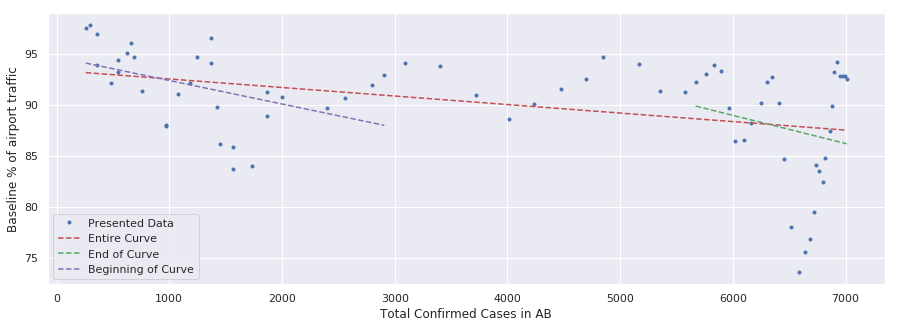

In [42]:
# Analyzing statistical correlation in --> Wave 1
first_wave = joined[joined['Date']<'2020-06-01']
plt.figure(figsize = (15,5))

"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.', label = 'Presented Data')
plt.xlabel("Total Confirmed Cases in AB")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)
# Moderate correlation
linearX = np.linspace(min(first_wave["Confirmed"]), max(first_wave["Confirmed"]))
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--', label = 'Entire Curve')

# Analyze the tail of the first wave: The last 30 days 
# i.e. when it tapered down in May
reg2 = stats.linregress(first_wave["Confirmed"].tail(30), first_wave["Baseline_smooth"].tail(30))
print(reg2.rvalue)
# No correlation
lin2 = np.linspace(min(first_wave["Confirmed"].tail(30)), max(first_wave["Confirmed"].tail(30)))
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--', label = 'End of Curve')

# Analyze the first month the curve: the month where it kept climbing up
reg3 = stats.linregress(first_wave["Confirmed"].head(30), first_wave["Baseline_smooth"].head(30))
print(reg3.rvalue)
# Moderate correlation
lin3 = np.linspace(min(first_wave["Confirmed"].head(30)), max(first_wave["Confirmed"].head(30)))
plt.plot(lin3, reg3.slope*lin3+ reg3.intercept,'m--', label = 'Beginning of Curve')
plt.legend()
plt.savefig('graphs/YEGWave.svg')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


0.9546486167317865
0.8153627169159418


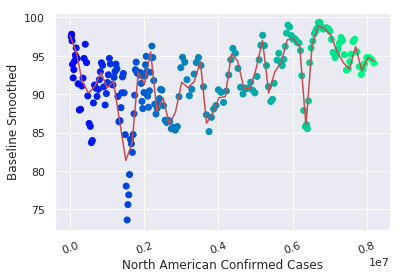

In [43]:
# This is to make sure both yeg and naCases start and end on the same dates
if (yeg.count().loc['Date'] != naCases.count().loc['Date']):
    na = naCases[["Date","Confirmed","New"]].join(yeg[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    na = na.dropna()

plt.scatter(na['Confirmed'],na['Baseline_smooth'],c=na['Date'],cmap='winter' )
plt.xlabel("North American Confirmed Cases")
plt.xticks(rotation=20)
plt.ylabel("Baseline Smoothed")

X = np.stack([na['Confirmed']], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,np.stack([na['Baseline_smooth']], axis =1))

poly_regress = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(2)
)
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,8200000)],axis=1)

plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
plt.savefig('graphs/YEGML.svg')

In [31]:
# ML with new cases, total cases, na cases: total + new, vs y= Baseline
# naCases --> Confirmed, New, New_smooth, Confirm_smooth
# joined --> Confirmed, Confirmed_smooth, Difference, Diff_smooth, Baseline_smooth, PercentOfBaseline

joined["Confirmed_smooth"] = confirmX
joined
# X --> na_confirm, na_new, bc_confirm, bc_new
X = naCases[["Confirm_smooth", "New_smooth", "Date"]].join(joined[["Confirmed_smooth","Diff_smooth","Date"]].set_index('Date'), on ='Date')
X = X.rename(columns={"Confirm_smooth": "na_confirm", "New_smooth":"na_new", "Confirmed_smooth":"ab_confirm", "Diff_smooth":"ab_new"})
X = X[["na_confirm","na_new","ab_confirm","ab_new"]].dropna()

# y --> joined['Baseline_smooth']
y = joined['Baseline_smooth'].rename(columns={"Baseline_smooth":"yvrBaseline"})

In [32]:
# GB regressor does the best out of all of them bc diff factors are weighed differently
# Also not that much data, so neural network doesn't really work
gbmodel = make_pipeline(
    MinMaxScaler(),
    GradientBoostingRegressor(n_estimators=50, max_depth=5)
    )
gbmodel.fit(X_train, y_train)

print(gbmodel.score(X_train,y_train), gbmodel.score(X_valid,y_valid))

0.9747901112806481 0.8337682674929575


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
